# Analysis of Community Detection Algorithms

This notebook provides a detailed analysis of the results from a comparative study of community detection algorithms. We will explore the performance of traditional methods (Louvain, Label Propagation, Girvan-Newman) and Graph Neural Network (GNN) based models (GCN, GraphSAGE) across several standard graph datasets.

The analysis is structured as follows:
1. **Dataset Characteristics**: A look at the properties of the datasets used.
2. **Understanding the Metrics**: An explanation of each evaluation metric, its value range, and its optimization goal.
3. **Results Visualization**: Visual comparison of the algorithms' performance on each dataset using bar plots.
4. **Discussion of Results**: A summary and interpretation of the key findings from the experiments.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
sns.set_theme(style="whitegrid", palette="magma")

## 1. Dataset Characteristics

First, let's understand the datasets we are working with. The properties of a graph can significantly influence the performance of community detection algorithms. For instance, GNNs typically require node features to learn meaningful representations, whereas traditional methods operate purely on the graph's topology.

In [22]:
from torch_geometric.datasets import KarateClub, Planetoid
from torch_geometric.utils import to_undirected
from deep_learning_methods import get_cora_subgraph_pyg
# Load datasets (adjust paths as needed)
karate_data = KarateClub()[0]
cora_data = Planetoid(root='/tmp/Cora', name='Cora')[0]
pubmed_data = Planetoid(root='/tmp/PubMed', name='PubMed')[0]


cora_subset_data = get_cora_subgraph_pyg(cora_data)

datasets = {
    'KarateClub': karate_data,
    'Cora_Subset': cora_subset_data,
    'Cora': cora_data,
    'PubMed': pubmed_data
}

stats = {
    'Dataset': [],
    'Nodes': [],
    'Edges': [],
    'Avg. Node Degree': [],
    'Node Feature Dim.': [],
    '# Classes / GT Communities': []
}

for name, data in datasets.items():
    num_nodes = data.num_nodes
    edge_index = to_undirected(data.edge_index)
    num_edges = edge_index.size(1) // 2
    avg_degree = (2 * num_edges) / num_nodes
    feat_dim = data.x.size(1) if data.x is not None else 0
    num_classes = int(data.y.max().item() + 1) if data.y is not None else 0

    stats['Dataset'].append(name)
    stats['Nodes'].append(num_nodes)
    stats['Edges'].append(num_edges)
    stats['Avg. Node Degree'].append(round(avg_degree, 2))
    stats['Node Feature Dim.'].append(feat_dim)
    stats['# Classes / GT Communities'].append(num_classes)

stats_df = pd.DataFrame(stats)
stats_df.set_index('Dataset')

Created PyG Cora subgraph with 150 nodes and 256 edges.


,Nodes,Edges,Avg. Node Degree,Node Feature Dim.,# Classes / GT Communities
Dataset,,,,,
KarateClub,34,78,4.59,34,4
Cora_Subset,150,256,3.41,1433,7
Cora,2708,5278,3.90,1433,7
PubMed,19717,44324,4.50,500,3


The KarateClub dataset is very small (34 nodes) and lacks high-dimensional node features, which may explain why GNNs don't show a clear advantage and can sometimes perform poorly (like GraphSage's negative modularity). In contrast, Cora and PubMed are much larger and have rich node features, providing a better playground for GNNs to learn effective node embeddings for community detection.

## 2. Understanding the Metrics

To interpret the results correctly, we need to understand what each metric measures. The metrics are divided into two categories: internal and external.

### Internal Metrics
These metrics evaluate the quality of a partition based only on the graph's structure, without any ground-truth information.

- **Modularity**: 
  - **What it is**: Measures the density of edges inside communities as compared to edges between communities. It quantifies how well a partitioning separates the graph into dense, well-defined clusters.
  - **Range**: `[-0.5, 1]`. Values closer to 1 indicate strong community structure.
  - **Goal**: **Maximize**.

- **Average Conductance**:
  - **What it is**: Measures the "cut" quality of the communities. For each community, it calculates the ratio of edges pointing outside the community to the total number of edges connected to it. A lower conductance means the community is well-isolated.
  - **Range**: `[0, 1]`. 
  - **Goal**: **Minimize**. A lower average conductance is better.

### External Metrics
These metrics compare the detected communities to the ground-truth labels.

- **Normalized Mutual Information (NMI)**:
  - **What it is**: An information-theoretic metric that measures the similarity between two sets of clusters (the predicted and the true ones). It corrects for chance, so a score of 0 means the similarity is what you'd expect by random chance.
  - **Range**: `[0, 1]`.
  - **Goal**: **Maximize**. A score of 1 indicates a perfect match.

- **Adjusted Rand Score (ARI)**:
  - **What it is**: Measures the similarity between two partitions, correcting for chance. It considers all pairs of nodes and counts pairs that are assigned in the same or different communities in both the predicted and true partitions.
  - **Range**: `[-1, 1]`. Negative values indicate disagreement, 0 is for random labeling, and 1 is a perfect match.
  - **Goal**: **Maximize**.

- **Fowlkes-Mallows Score (FMS)**:
  - **What it is**: The geometric mean of precision and recall. It measures the similarity of the clustering results by considering the number of pairs of points that are in the same cluster in both the true and predicted partitions.
  - **Range**: `[0, 1]`.
  - **Goal**: **Maximize**.

## 3. Results Visualization

Now, let's load the results and visualize them as your friend suggested. We will create a separate plot for each dataset, with bar plots comparing the algorithms across the different metrics. We will handle `Avg_Conductance` separately since its optimization direction is different.

In [23]:
from io import StringIO

with open('community_detection_results.md', 'r') as f:
    md_text = f.read()

lines = md_text.splitlines()
table_lines = [line for line in lines if '|' in line and not line.strip().startswith('#')]

table_lines = [line for line in table_lines if not set(line.strip()) <= set('|- ')]

table_str = '\n'.join(table_lines)
results_df = pd.read_csv(StringIO(table_str), sep='|').dropna(axis=1, how='all')
results_df.columns = [col.strip() for col in results_df.columns]
results_df = results_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\jmlim\AppData\Local\Temp\ipykernel_10808\70495966.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


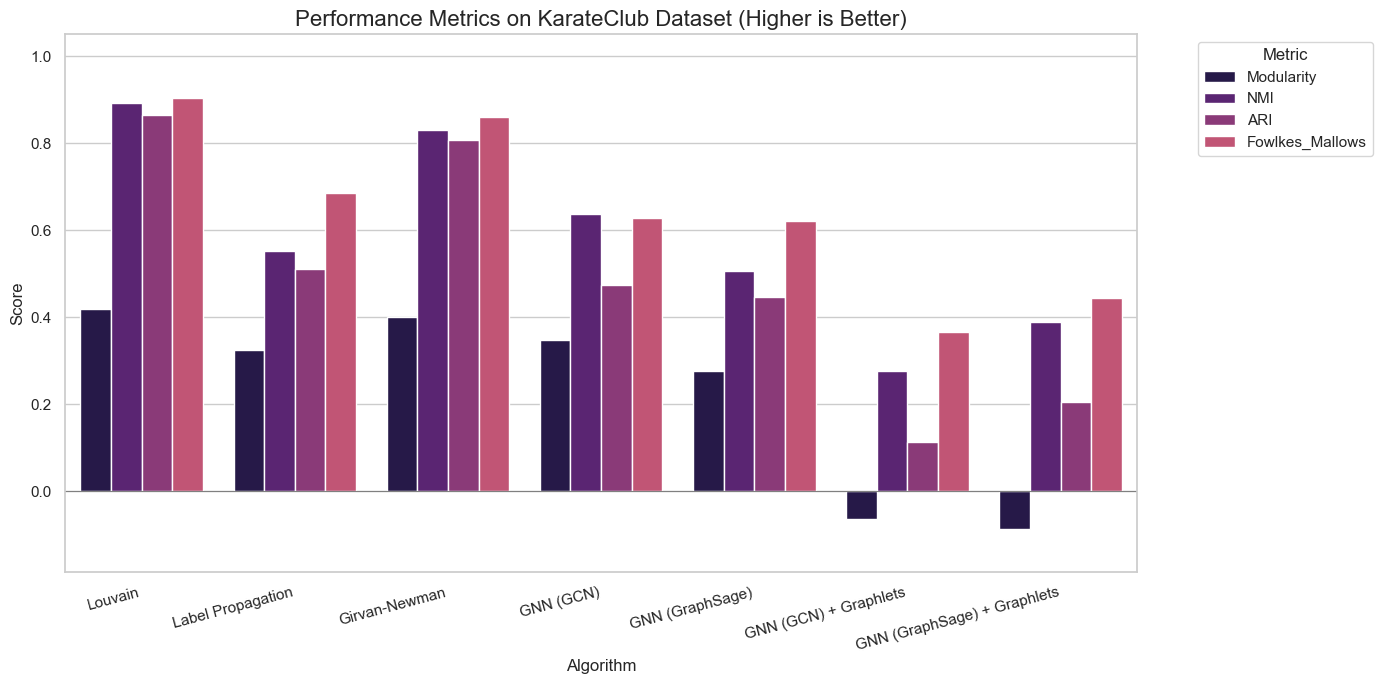

C:\Users\jmlim\AppData\Local\Temp\ipykernel_10808\3801098827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Algorithm', y=metric_to_plot_min, ax=ax1,


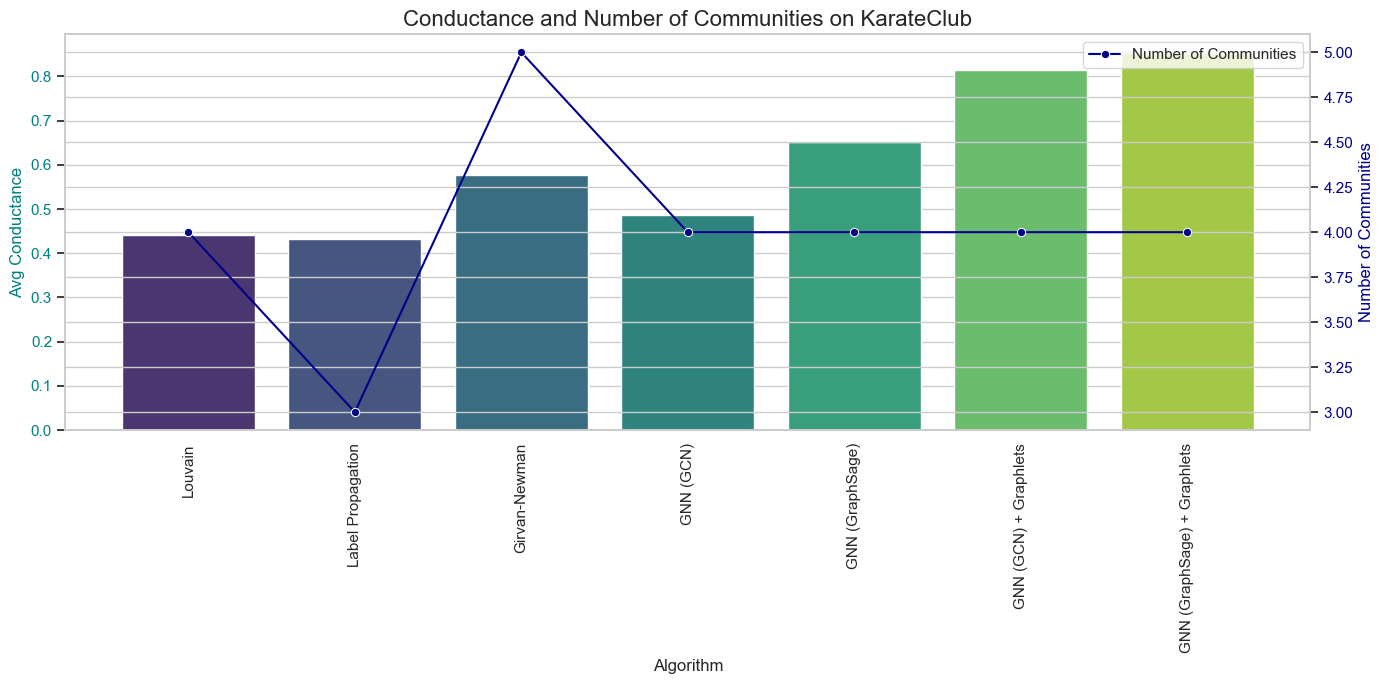

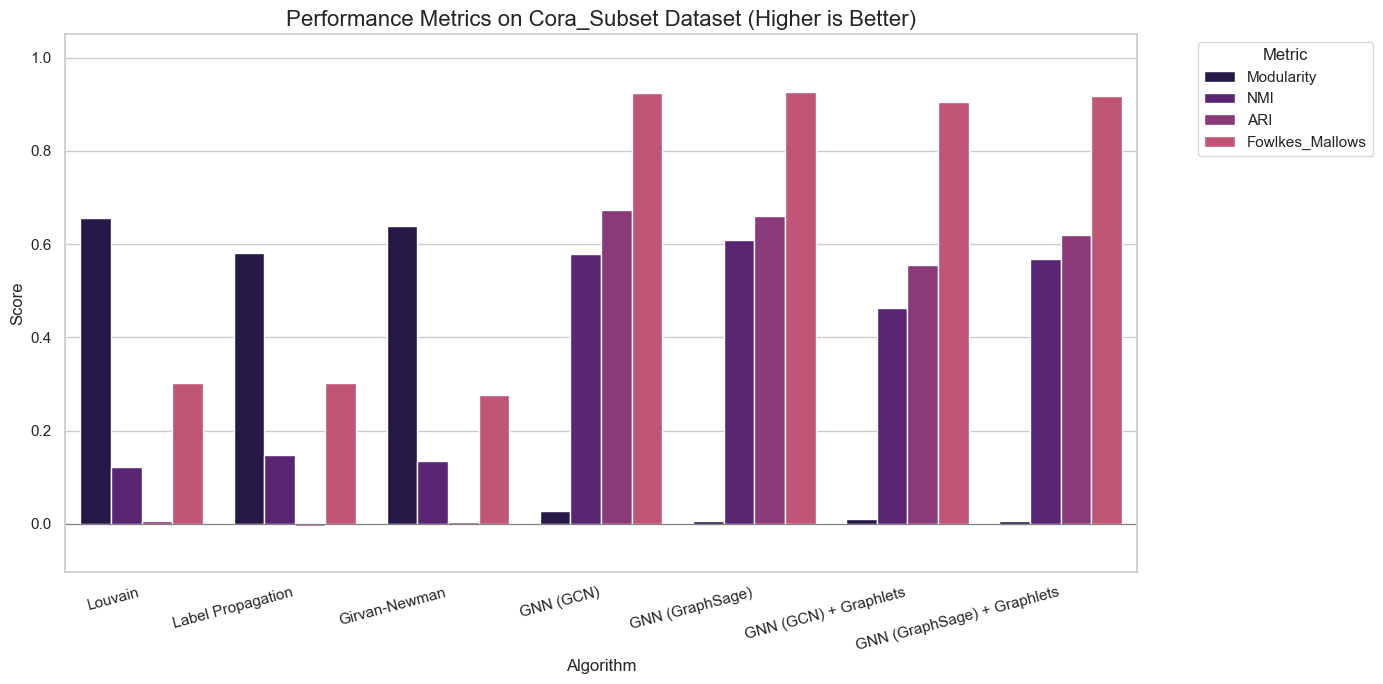

C:\Users\jmlim\AppData\Local\Temp\ipykernel_10808\3801098827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Algorithm', y=metric_to_plot_min, ax=ax1,


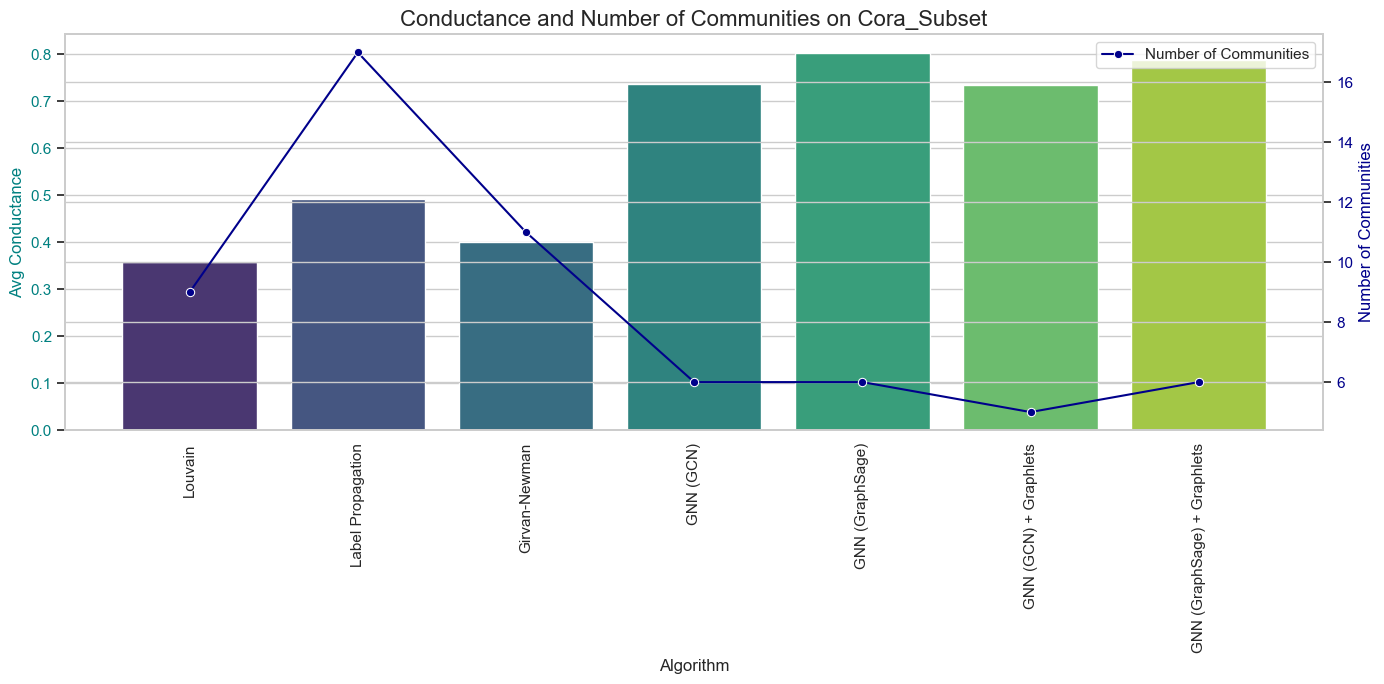

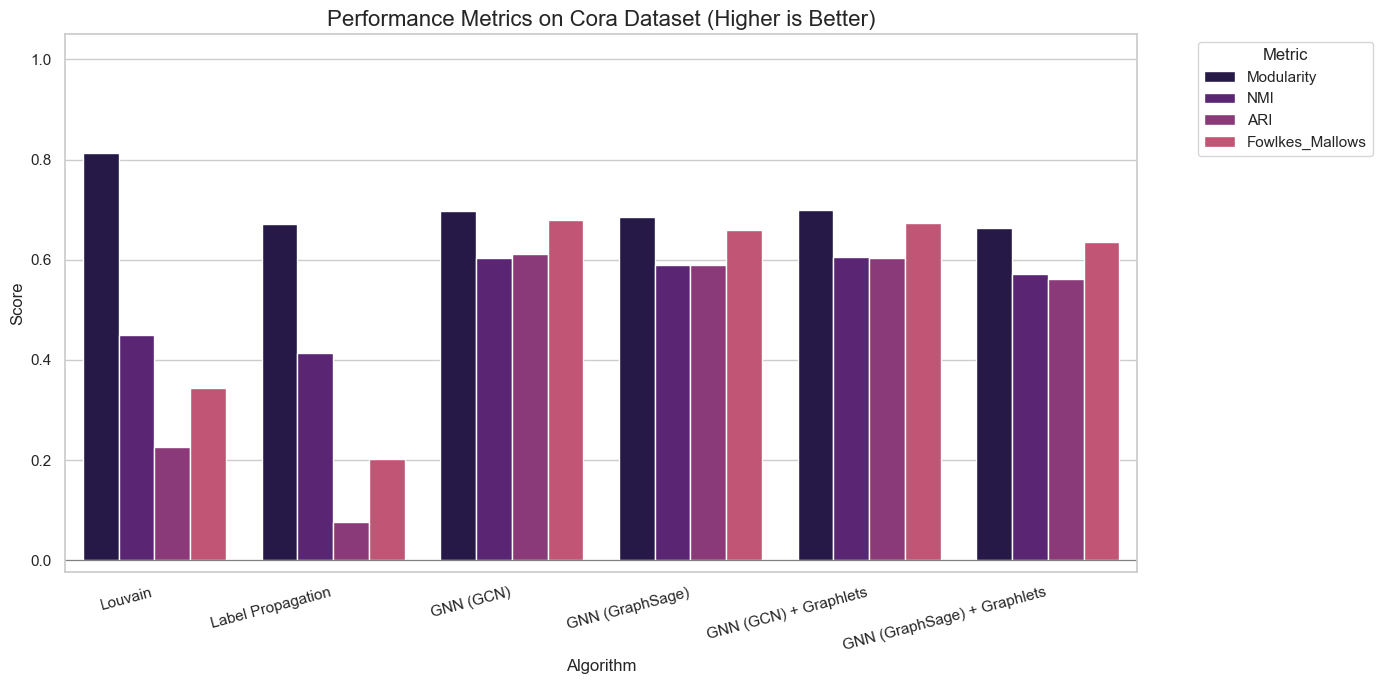

C:\Users\jmlim\AppData\Local\Temp\ipykernel_10808\3801098827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Algorithm', y=metric_to_plot_min, ax=ax1,


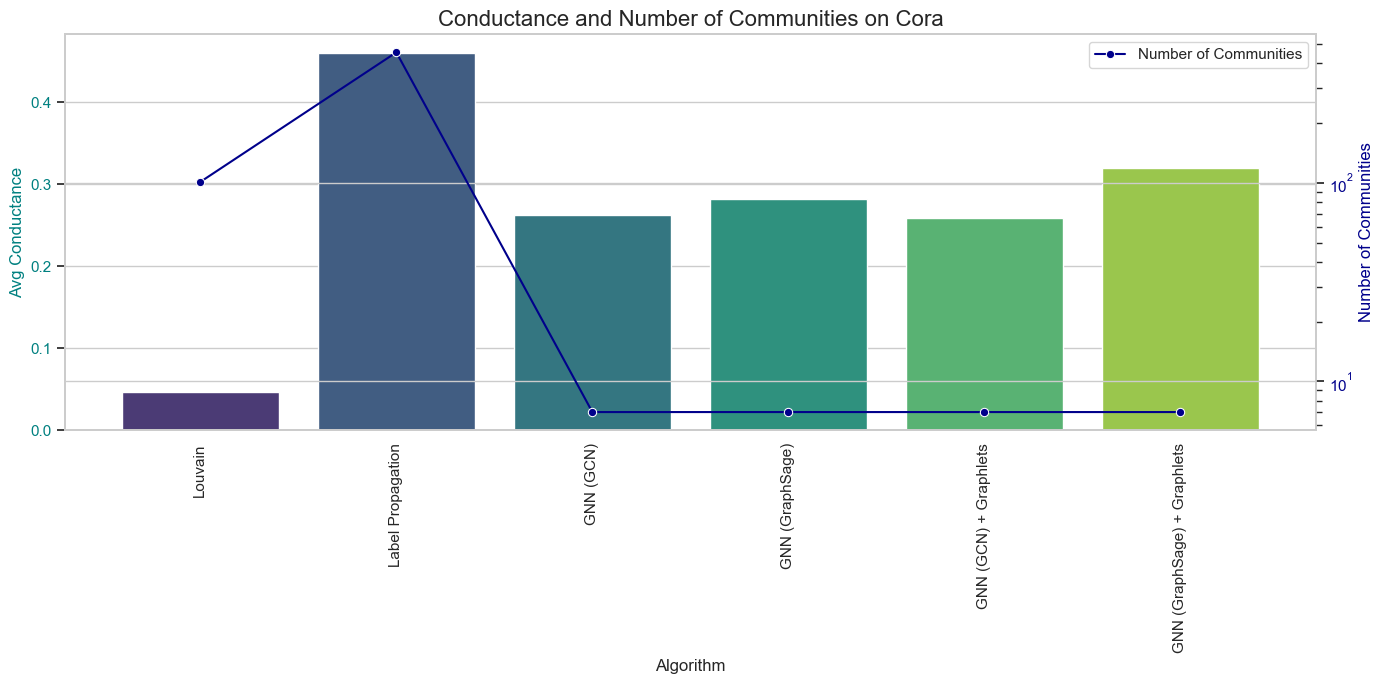

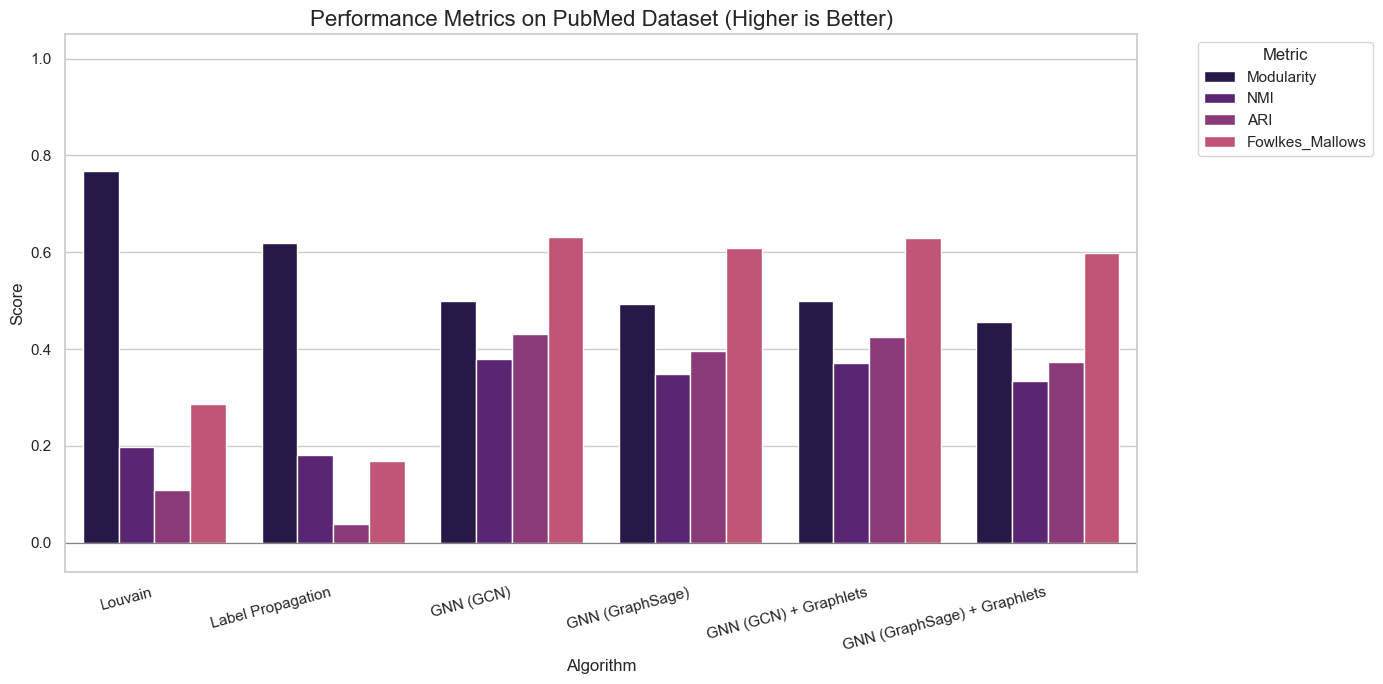

C:\Users\jmlim\AppData\Local\Temp\ipykernel_10808\3801098827.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Algorithm', y=metric_to_plot_min, ax=ax1,


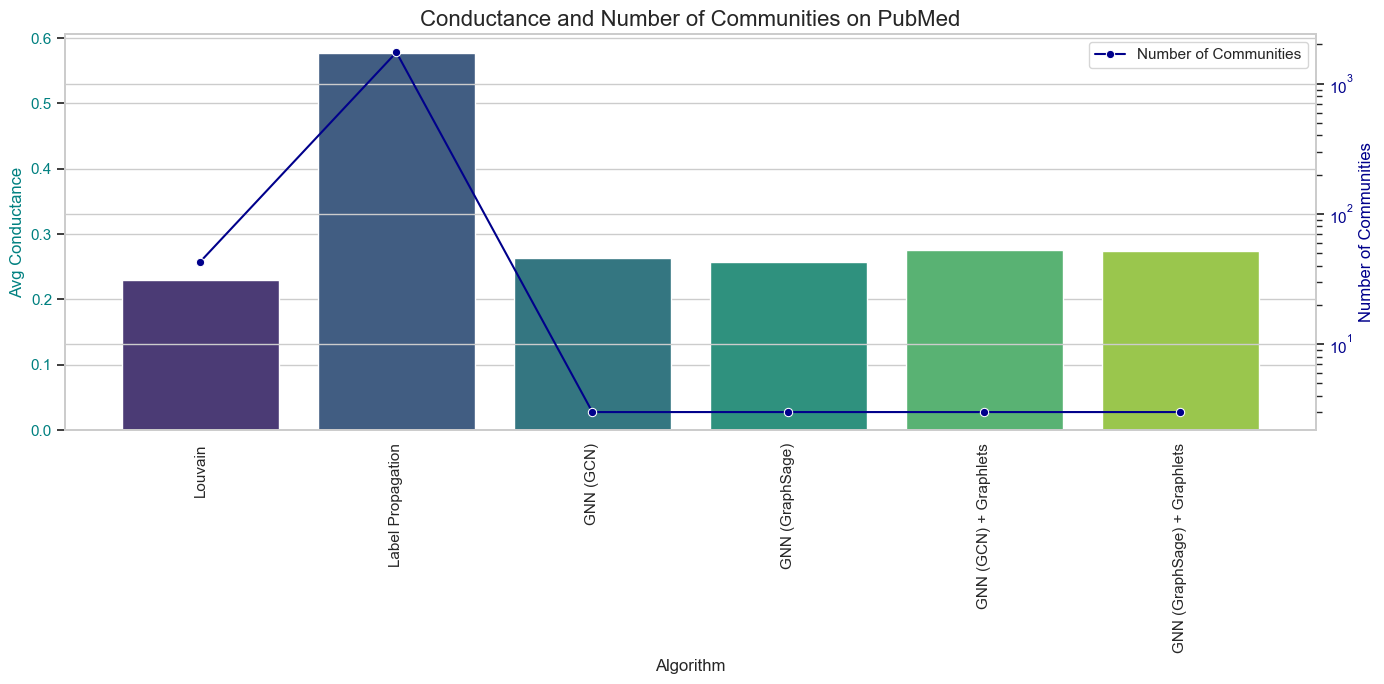

In [24]:
def plot_metrics(df, dataset_name):
    """Plots metrics for a given dataset."""
    data = df[df['Dataset'] == dataset_name].copy()

    cols_to_numeric = ['Num_Communities', 'Modularity', 'Avg_Conductance', 'NMI', 'ARI', 'Fowlkes_Mallows']
    for col in cols_to_numeric:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')


    metrics_to_plot_max = ['Modularity', 'NMI', 'ARI', 'Fowlkes_Mallows']
    metric_to_plot_min = 'Avg_Conductance'

    melted_data_max = data.melt(id_vars='Algorithm', value_vars=metrics_to_plot_max, var_name='Metric', value_name='Score')
    melted_data_max['Score'] = pd.to_numeric(melted_data_max['Score'], errors='coerce')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=melted_data_max, x='Algorithm', y='Score', hue='Metric')
    plt.title(f'Performance Metrics on {dataset_name} Dataset (Higher is Better)', fontsize=16)
    plt.ylabel('Score')
    plt.xlabel('Algorithm')
    plt.xticks(rotation=15, ha='right')
    score_min = melted_data_max['Score'].min()
    if np.isnan(score_min):
        plt.ylim(-0.2, 1.05)
    else:
        plt.ylim(max(score_min - 0.1, -0.2), 1.05)
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots(figsize=(14, 7))

    sns.barplot(data=data, x='Algorithm', y=metric_to_plot_min, ax=ax1,
                palette="viridis", label='Avg Conductance (Lower is Better)')
    ax1.set_ylabel('Avg Conductance', color='teal')
    ax1.tick_params(axis='y', labelcolor='teal')
    ax1.set_xlabel('Algorithm')
    
    plt.xticks(rotation=90, ha='center')

    ax2 = ax1.twinx()
    sns.lineplot(data=data, x='Algorithm', y='Num_Communities', ax=ax2,
                 color='darkblue', marker='o', label='Number of Communities')
    ax2.set_ylabel('Number of Communities', color='darkblue')
    ax2.tick_params(axis='y', labelcolor='darkblue')
    if data['Num_Communities'].max() > 100:
        ax2.set_yscale('log')

    plt.title(f'Conductance and Number of Communities on {dataset_name}', fontsize=16)
    
    fig.tight_layout()  
    plt.show()
datasets = results_df['Dataset'].unique()

for dataset in datasets[1:]:
    plot_metrics(results_df, dataset)

## 4. Discussion of Results

The visualizations provide a clear picture of each algorithm's performance.

### Key Observations:

- **KarateClub**: On this small, simple graph, the traditional **Girvan-Newman** and **Louvain** algorithms perform exceptionally well on both internal (Modularity) and external (NMI, ARI) metrics. The GNNs, especially GraphSAGE, struggle, likely due to the small amount of data, which is insufficient for effective training. GraphSAGE's negative modularity score indicates that the communities it found are worse than a random partition.

- **Cora Subset**: Here, we see a more nuanced story. **Louvain** still dominates in Modularity, as it's designed to optimize it. However, the **GNN models (GCN and GraphSAGE) clearly outperform all traditional methods on the external metrics (NMI, ARI, FMS)**. This is a crucial finding: GNNs are better at finding communities that align with the ground truth, thanks to their ability to leverage node features during training.

- **Cora (Full)**: The trend continues on the full Cora dataset. **Louvain** achieves the highest modularity but produces a very large number of communities (101). The **GNN models** provide the best results on all external metrics, identifying a number of communities (7) that matches the ground-truth classes. Their conductance is higher than Louvain's but still reasonable, suggesting well-defined community boundaries.

- **PubMed**: The results on this large dataset are similar to Cora. **Louvain** and **Label Propagation** find a huge number of communities, which may not be practically useful. The **GNNs**, in contrast, find a number of communities that matches the ground truth (3) and achieve significantly better external validation scores. GraphSAGE and GCN perform almost identically on this dataset.

- **Impact of Graphlet-Enhanced Features**: The experiments show that augmenting or replacing node features with simple graphlet-based features (triangle counts) had a mixed impact. On the **KarateClub** dataset, which lacks rich initial features, using only graphlet features significantly worsened the performance of both GCN and GraphSAGE. This suggests that basic structural features alone are not sufficient for these models on small graphs. Conversely, on the feature-rich **Cora and PubMed** datasets, augmenting the existing features with graphlet features resulted in only marginal changes, with performance being very similar to the baseline GNNs. This indicates that when strong node features are already present, simple structural features may not provide significant additional value for these GNN architectures.

### Conclusion

This analysis demonstrates a clear trade-off between traditional and deep learning-based community detection methods:

1.  **Traditional Algorithms (e.g., Louvain)** are excellent for optimizing graph-native metrics like modularity and are fast and easy to use. However, they may not find communities that align with external, feature-based ground truths and can sometimes produce an impractically large number of clusters.
2.  **GNN-based Methods (GCN, GraphSAGE)** excel at finding semantically meaningful communities that align with ground-truth data, especially on datasets with rich node features. Their performance on smaller graphs or graphs without informative features can be suboptimal. They represent the state-of-the-art for semi-supervised community detection tasks.